In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil

In [4]:
gpus = tf.config.experimental.list_logical_devices('GPU')

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
image_size = 256
batch_size = 32
epochs = 50

In [5]:
data_folder = 'data'
'''
# Class folder names as the represent classes of subfolders
class_folder_name = []
for name in os.listdir(data_folder):
    class_name = name.split('_')[0]
    if class_name not in class_folder_name:
        class_folder_name.append(class_name)

# Get the list of all subdirectories in the 'data' folder
all_subdirs = [d for d in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, d))]

# Create a new folder to group all subfolders
for class_name in class_folder_name:
    new_folder_path = os.path.join(data_folder, class_name)
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Filter only the subdirectories
    target_classes = [d for d in all_subdirs if str(class_name+'_') in d]
    # Move the filtered subdirectories to the new folder
    for target_class in target_classes:
        source_path = os.path.join(data_folder, target_class)
        destination_path = os.path.join(new_folder_path, target_class)
        shutil.move(source_path, destination_path)'''

"\n# Class folder names as the represent classes of subfolders\nclass_folder_name = []\nfor name in os.listdir(data_folder):\n    class_name = name.split('_')[0]\n    if class_name not in class_folder_name:\n        class_folder_name.append(class_name)\n\n# Get the list of all subdirectories in the 'data' folder\nall_subdirs = [d for d in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, d))]\n\n# Create a new folder to group all subfolders\nfor class_name in class_folder_name:\n    new_folder_path = os.path.join(data_folder, class_name)\n    os.makedirs(new_folder_path, exist_ok=True)\n    \n    # Filter only the subdirectories\n    target_classes = [d for d in all_subdirs if str(class_name+'_') in d]\n    # Move the filtered subdirectories to the new folder\n    for target_class in target_classes:\n        source_path = os.path.join(data_folder, target_class)\n        destination_path = os.path.join(new_folder_path, target_class)\n        shutil.move(source_path, des

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data\Tomato",
    shuffle=True,
    image_size=(image_size,image_size),
    batch_size=batch_size,
)

Found 16011 files belonging to 10 classes.


In [8]:
class_names = dataset.class_names
num_classes = len(class_names)
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato_Target_Spot',
 'Tomato_Tomato_YellowLeaf_Curl_Virus',
 'Tomato_Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
len(dataset)

501

(32, 256, 256, 3)
[6 1 6 6 5 2 9 1 6 6 9 0 4 6 0 7 8 6 5 9 2 1 5 6 0 7 9 2 3 5 4 2]


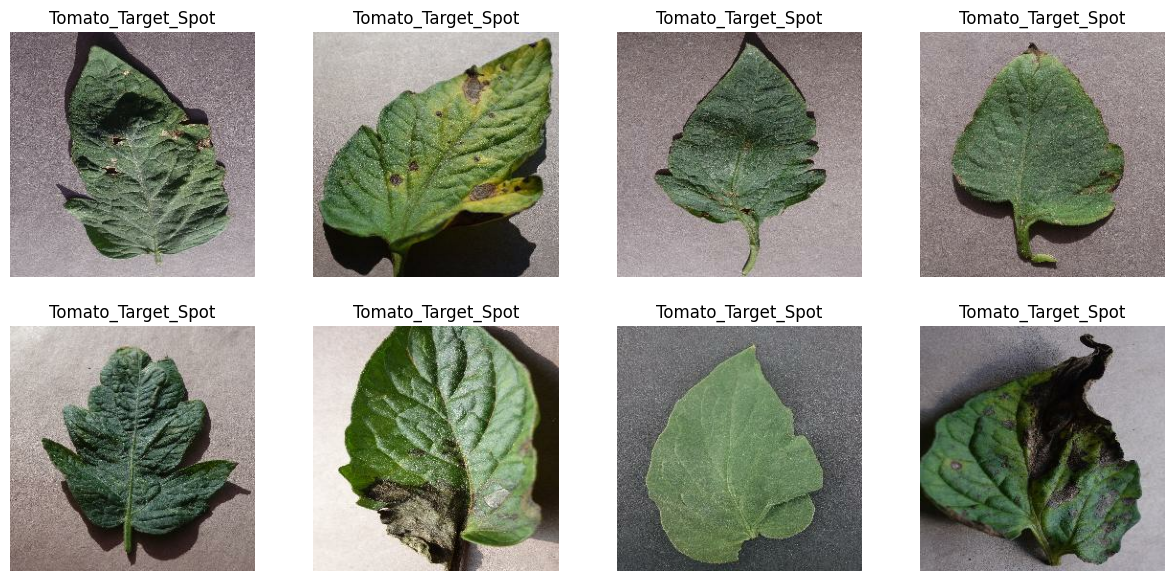

In [12]:
plt.figure(figsize=(15,7))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(8):
        ax = plt.subplot(2,4,i+1)
        plt.imshow(image_batch[i].numpy().astype(int)) 
        plt.axis('off')
        plt.title(class_names[label_batch[0]])

In [13]:
def dataset_partition(dataset, train_split=0.8, val_split=0.1, test_plit=0.1, shuffle=True, shuffle_size=10000):
    data_size = len(dataset)

    # Shuffle if True
    if shuffle:
        dataset.shuffle(shuffle_size, seed=0)
    
    # Train and Validation size
    train_size = int(train_split*data_size)
    val_size = int(val_split*data_size)
    
    # Take dataset
    train = dataset.take(train_size)
    val = dataset.skip(train_size).take(val_size)
    test = dataset.skip(train_size).skip(val_size)

    return train, val, test

In [14]:
train, val, test = dataset_partition(dataset)

In [15]:
print(len(train), len(val), len(test))
print(train)

400 50 51
<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [16]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) 

In [17]:
from tensorflow.keras import layers, models

In [18]:
# Data preprocessing
data_preprocess = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(image_size,image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])

# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

In [20]:
from tensorflow.keras import optimizers 
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

# Set up compile
opt_adam = optimizers.Adam(learning_rate=0.0001, decay=1e-6)
metric = 'accuracy'
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

#Callback
logdir = 'logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
earlystop_callback = EarlyStopping(monitor='val_loss', patience=5)

In [21]:
def plot_loss_accuracy(hist):
    # Plot performance of model
    fig = plt.figure(figsize=(10,5))
    ax = plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], color='orange', label='loss')
    plt.plot(hist.history['val_loss'], color='teal', label='val loss')


    ax = plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], color='orange', label='accuracy')
    plt.plot(hist.history['val_accuracy'], color='teal', label='val accuracy')


    return None

In [22]:
# Save model with updated version
os.makedirs("models", exist_ok=True)
def save_model(model):
    model_ver = max([int(i[len("model_v"):]) for i in os.listdir("models")]+[0]) + 1
    model.save(f"models/model_v{model_ver:02d}")
    return None

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D

input_shape = (batch_size, image_size, image_size, 3)

# Build CNN model

model = models.Sequential([
    data_preprocess,
    data_augmentation,
    
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax'),

])

model.build(input_shape=input_shape)

model.summary()

NameError: name 'input_shape' is not defined

In [24]:
model.compile(
    optimizer=opt_adam,
    loss=loss,
    metrics=[metric],
)

In [208]:
hist = model.fit(
    train,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val,
    shuffle=True,
    callbacks=[tensorboard_callback]
)

Epoch 1/50


54/54 [==============================] - 7s 104ms/step - loss: 0.2830 - accuracy: 0.9057 - val_loss: 3.1286 - val_accuracy: 0.5052
Epoch 2/50
54/54 [==============================] - 5s 100ms/step - loss: 0.1268 - accuracy: 0.9543 - val_loss: 5.7237 - val_accuracy: 0.5052
Epoch 3/50
54/54 [==============================] - 5s 99ms/step - loss: 0.0916 - accuracy: 0.9641 - val_loss: 7.2368 - val_accuracy: 0.5052
Epoch 4/50
54/54 [==============================] - 5s 99ms/step - loss: 0.0604 - accuracy: 0.9763 - val_loss: 7.7588 - val_accuracy: 0.5052
Epoch 5/50
54/54 [==============================] - 5s 100ms/step - loss: 0.0573 - accuracy: 0.9803 - val_loss: 8.5590 - val_accuracy: 0.5052
Epoch 6/50
54/54 [==============================] - 5s 99ms/step - loss: 0.0466 - accuracy: 0.9832 - val_loss: 7.5310 - val_accuracy: 0.5052
Epoch 7/50
54/54 [==============================] - 5s 99ms/step - loss: 0.0460 - accuracy: 0.9797 - val_loss: 7.3898 - val_accuracy: 0.5052
Epoch 8/50
54/54 [===

8/8 [==============================] - 1s 59ms/step - loss: 0.0278 - accuracy: 0.9871


[0.027760600671172142, 0.9870689511299133]

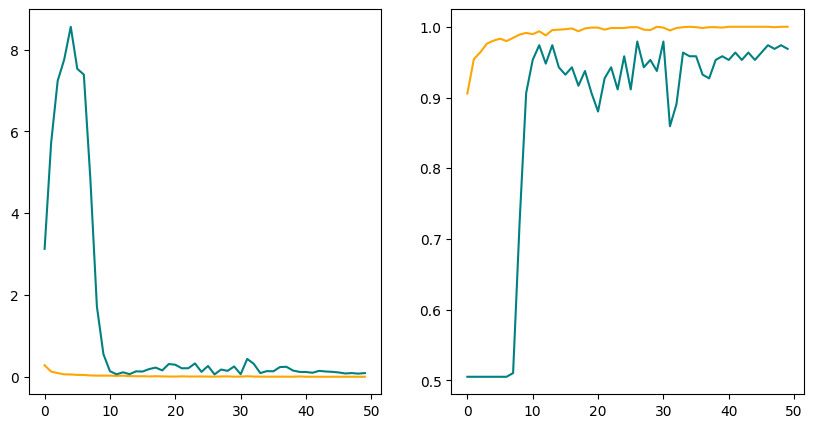

In [209]:
plot_loss_accuracy(hist)
scores = model03.evaluate(test)
scores

In [210]:
save_model(model)

INFO:tensorflow:Assets written to: models/model_v03\assets


In [ ]:
for image_batch, label_batch in test.take(1):
    first_image = image_batch[0].numpy().astype(int)
    first_label = class_names[label_batch[0].numpy()]
    prediction_batch = model01.predict(image_batch)
    predict_label = class_names[np.argmax(prediction_batch[0])]
    print(f'''
    Actual label: {first_label}
    Predict label: {predict_label}
    ''')
    plt.imshow(first_image)

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0) #Create a batch

    predictions = model.predict(img_array)

    predict_label = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)

    return predict_label, confidence

In [ ]:
is_break = False
while not is_break:
    for images, labels in test.take(1):
        num_img = 9
        if len(images)>=num_img:
            is_break = True
            fig = plt.figure(figsize=(10,10))
            for i in range(num_img):
                ax = plt.subplot(3,3,i+1)
                predict_label, confidence = predict(model01, images[i])
                actual_label = class_names[labels[i]]
                plt.imshow(images[i].numpy().astype(int))
                plt.title(f'Actual: {actual_label},\nPredict: {predict_label}, \n Confidence: {confidence}%', fontsize=12)
                plt.axis('off')
            fig.tight_layout()